In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data
from torch.utils.data import DataLoader,TensorDataset
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

from utils.assimilate import run_assimilation
from models import cVAE, cLSTM

In [2]:
# TODO
# - control flow for if models don't exist
# - explain what I'm doing at points

### Load/Process Data:

In [3]:
background_path = 'data/Ferguson_fire_background.npy'
background_data = np.array(np.load(open(background_path,'rb')))
background_dataset = TensorDataset(torch.Tensor(background_data))

obs_path = 'data/Ferguson_fire_obs.npy'
obs_data = np.array(np.load(open(obs_path,'rb')))
obs_dataset = TensorDataset(torch.Tensor(obs_data))

### Load Models:

In [4]:
device = 'cpu'
cvae = cVAE.VAE_Conv(device).to(device)
clstm = cLSTM.ConvLSTM(input_dim=1,
                 hidden_dim=16,
                 kernel_size=(3, 3),
                 num_layers=1,
                 batch_first=True,
                 bias=True,
                 return_all_layers=False).to(device)
                    
if not os.path.exists('models/cvae_best.pt'):
    print('No trained model available')  # do something else here
else:
    cvae.load_state_dict(torch.load('models/cvae_best.pt'))
    clstm.load_state_dict(torch.load('models/clstm.pt', map_location=torch.device('cpu')))
    
cvae.eval()
clstm.eval();

### Generate Model Predictions:

Explain what I'm doing here...

In [5]:
def predict(model, background_dataset, timesteps):
    preds = []
    for i in range(len(background_dataset)-1):
        pred,_ = model(background_dataset[i][0].unsqueeze(0)) 
        for j in range(timesteps):
            if j == 0:
                pred,_ = model(background_dataset[i][0].unsqueeze(0)) 
            else:
                pred, _ = model(pred)           
        preds.append(pred.detach().numpy())
    preds = np.array(preds).squeeze() 
    return preds

In [6]:
cvae_preds = predict(cvae, background_dataset, 10)

In [7]:
lstm_background_data = np.reshape(background_data[:-1], (background_data[:-1].shape[0],1,1,background_data.shape[1],background_data.shape[2]))
_, clstm_preds = clstm(torch.Tensor(lstm_background_data))
clstm_preds = clstm_preds.detach().numpy().squeeze()

### Compress predictions and observed data:

Explain what I'm doing here...

In [8]:
pca = PCA(n_components = 4)

obs_data_1D = np.reshape(obs_data,(obs_data.shape[0],obs_data.shape[1]*obs_data.shape[2]))
obs_data_compr = pca.fit_transform(obs_data_1D)

cvae_preds_1D = np.reshape(cvae_preds,(cvae_preds.shape[0],cvae_preds.shape[1]*cvae_preds.shape[2]))
cvae_preds_compr = pca.transform(cvae_preds_1D)

In [9]:
clstm_preds_1D = np.reshape(clstm_preds,(clstm_preds.shape[0],clstm_preds.shape[1]*clstm_preds.shape[2]))
clstm_preds_compr = pca.transform(clstm_preds_1D)

### Perform data assimilation (DA):

Explain what I'm doing here

In [12]:
cvae_assimilated_preds = run_assimilation(cvae_preds_compr, obs_data_compr)
cvae_assimilated_preds = np.array(pca.inverse_transform(cvae_assimilated_preds))

In [13]:
clstm_assimilated_preds = run_assimilation(clstm_preds_compr, obs_data_compr)
clstm_assimilated_preds = np.array(pca.inverse_transform(clstm_assimilated_preds))

### MSE, before vs after DA:

In [14]:
vae_before = mean_squared_error(obs_data_1D[1:], cvae_preds_1D)
vae_after = mean_squared_error(obs_data_1D[1:], cvae_assimilated_preds)

print(f'CVAE MSE (in physical space) before DA: {vae_before}')
print(f'CVAE MSE (in physical space) after DA: {vae_after}')

CVAE MSE (in physical space) before DA: 0.08010059861722035
CVAE MSE (in physical space) after DA: 0.0163331288537813


In [15]:
lstm_before = mean_squared_error(obs_data_1D[1:], clstm_preds_1D)
lstm_after = mean_squared_error(obs_data_1D[1:], clstm_assimilated_preds)

print(f'CLSTM MSE (in physical space) before DA: {lstm_before}')
print(f'CLSTM MSE (in physical space) after DA: {lstm_after}')

CLSTM MSE (in physical space) before DA: 0.06630908206815017
CLSTM MSE (in physical space) after DA: 0.027350145936245452


### Plot results (actual vs forecasted vs assimilated forecasted):

### Objective 1 Model (ConvVAE):

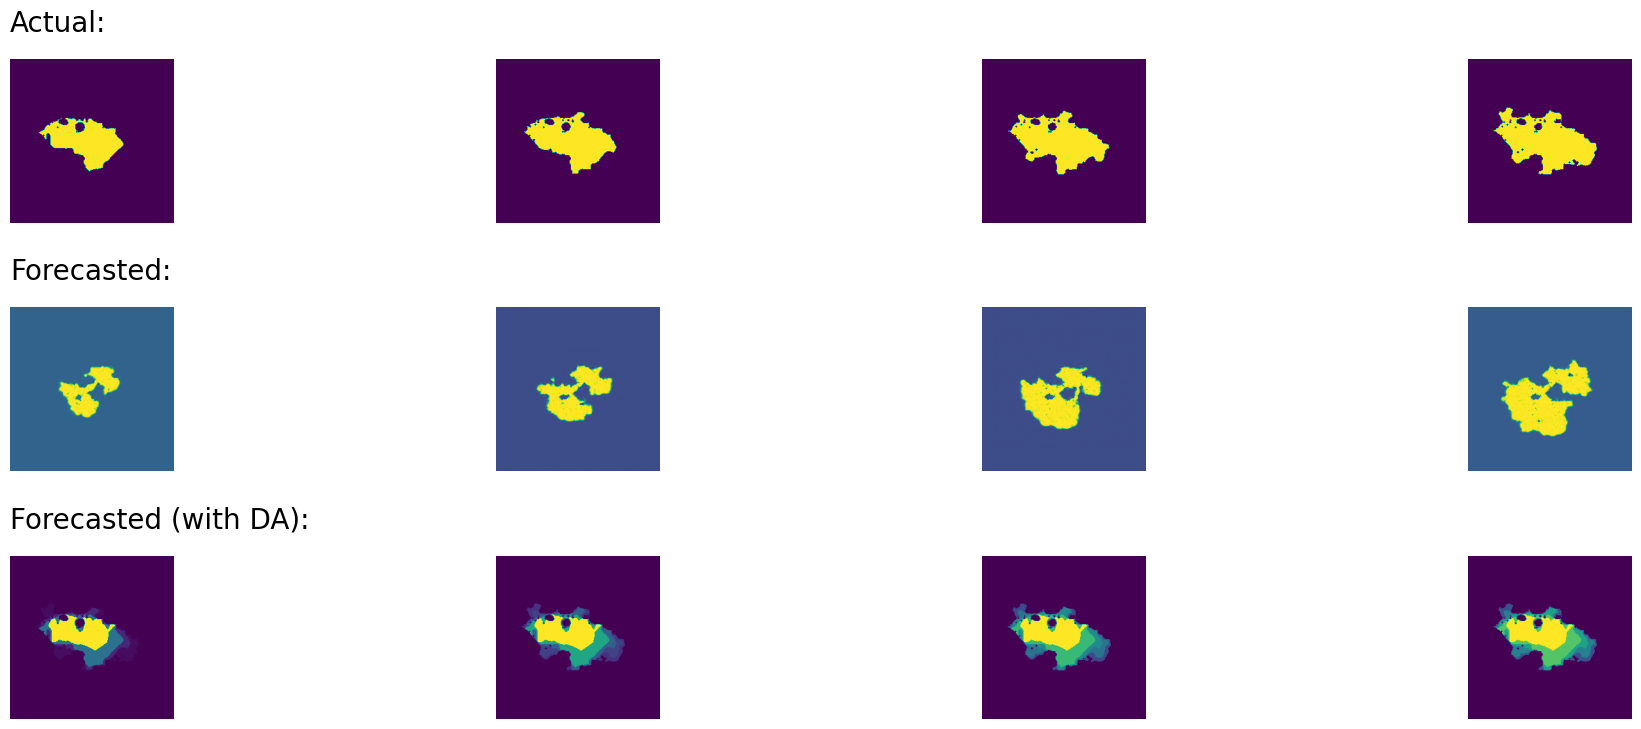

In [16]:
fig, ax = plt.subplots(3, 4, figsize=[20, 8])
fig.tight_layout(pad=4)
cvae_assimilated_preds = np.reshape(cvae_assimilated_preds, (cvae_assimilated_preds.shape[0], obs_data.shape[1],obs_data.shape[2]))
for n in range(len(background_data)-1):
    ax[0, n].imshow(obs_data[n+1])
    ax[0, n].axis('off')
    ax[1, n].imshow(cvae_preds[n])
    ax[1, n].axis('off')
    ax[2, n].imshow(cvae_assimilated_preds[n])
    ax[2, n].axis('off')    
    if n==0:
        ax[0,n].set_title('Actual:', fontsize=20, pad=20, loc='left')
        ax[1,n].set_title('Forecasted:', fontsize=20, pad=20, loc='left')
        ax[2,n].set_title('Forecasted (with DA):', fontsize=20, pad=20, loc='left')

### Objective 2 Model (ConvLSTM):

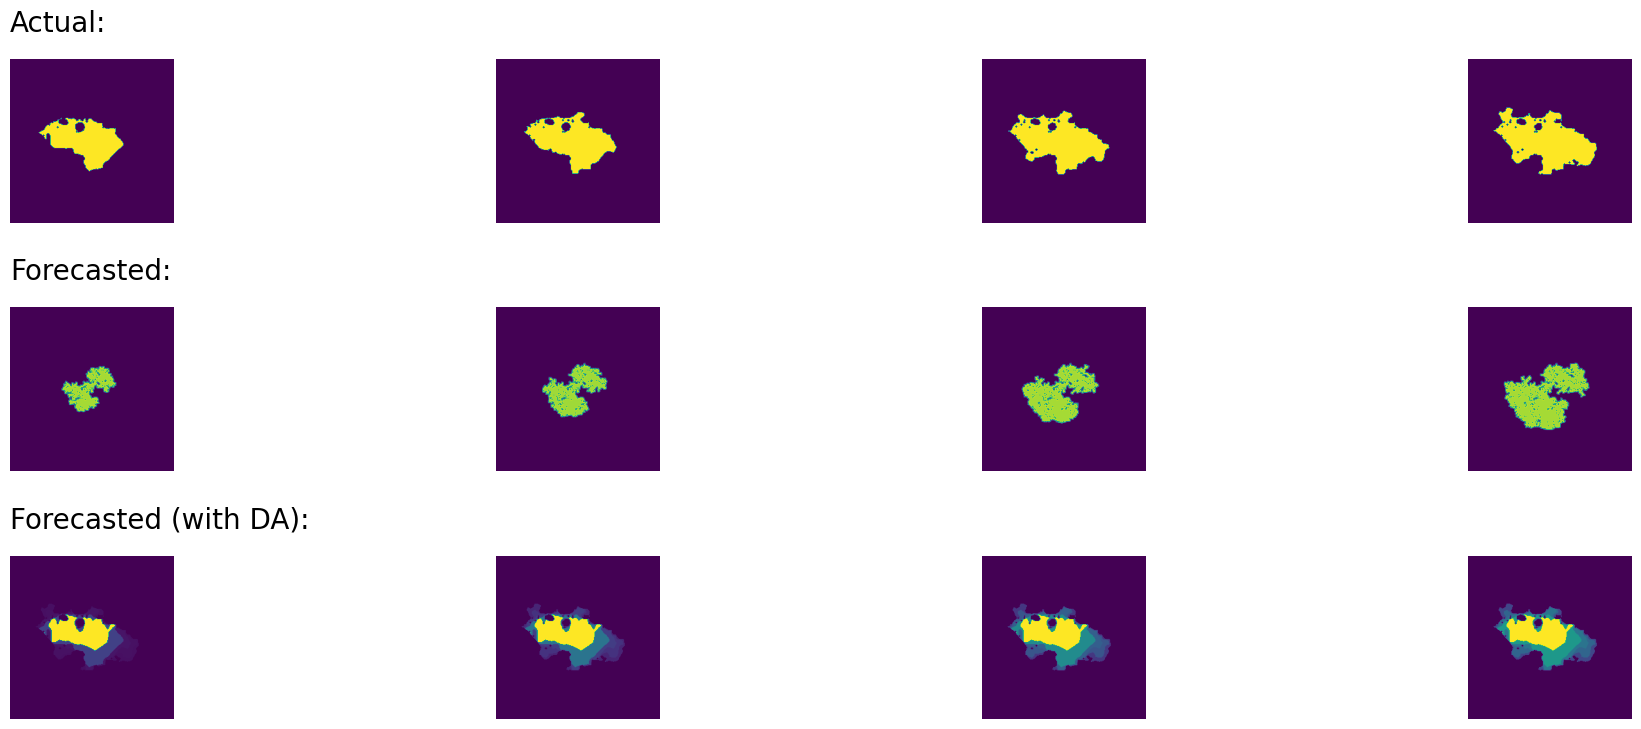

In [17]:
fig, ax = plt.subplots(3, 4, figsize=[20, 8])
fig.tight_layout(pad=4)
clstm_assimilated_preds = np.reshape(clstm_assimilated_preds, (clstm_assimilated_preds.shape[0], obs_data.shape[1],obs_data.shape[2]))
for n in range(len(background_data)-1):
    ax[0, n].imshow(obs_data[n+1])
    ax[0, n].axis('off')
    ax[1, n].imshow(clstm_preds[n])
    ax[1, n].axis('off')
    ax[2, n].imshow(clstm_assimilated_preds[n])
    ax[2, n].axis('off')    
    if n==0:
        ax[0,n].set_title('Actual:', fontsize=20, pad=20, loc='left')
        ax[1,n].set_title('Forecasted:', fontsize=20, pad=20, loc='left')
        ax[2,n].set_title('Forecasted (with DA):', fontsize=20, pad=20, loc='left')